In [1]:
#!pip install tf-keras
#!pip install scikit-learn

In [2]:
import os
import shutil
from IPython.display import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import sys
import numpy as np
sys.path.append('aux_scripts.py')

i=0

2025-01-08 16:37:52.701484: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 16:37:52.834881: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 16:37:52.917062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736350673.011985   19792 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736350673.037737   19792 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 16:37:53.230613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## NN creation and training

### Split the data into training and validation sets

In [3]:
# Function to clear a directory
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the directory and its contents
    os.makedirs(directory, exist_ok=True)  # Recreate an empty directory

# Function to copy files to target directories
def copy_files(file_list, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for file in file_list:
        shutil.copy(file, target_dir)

# Function to split dataset
def split_dataset(source_dir, test_size=0.2):
    files = os.listdir(source_dir)
    files = [os.path.join(source_dir, f) for f in files]
    train_files, temp_files = train_test_split(files, test_size=test_size, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    return train_files, val_files, test_files

# Split the dataset
def split_and_copy(train_dir, val_dir, test_dir):

    # Clear the train, val, and test directories before splitting
    clear_directory(train_dir)
    clear_directory(val_dir)
    clear_directory(test_dir)

    mask_train_files, mask_val_files, mask_test_files = split_dataset(mask_dir)
    no_mask_train_files, no_mask_val_files, no_mask_test_files = split_dataset(no_mask_dir)

    # Copy files to train/val/test directories
    copy_files(mask_train_files, os.path.join(train_dir, 'mask'))
    copy_files(mask_val_files, os.path.join(val_dir, 'mask'))
    copy_files(mask_test_files, os.path.join(test_dir, 'mask'))
    copy_files(no_mask_train_files, os.path.join(train_dir, 'no_mask'))
    copy_files(no_mask_val_files, os.path.join(val_dir, 'no_mask'))
    copy_files(no_mask_test_files, os.path.join(test_dir, 'no_mask'))

In [4]:
# Paths to directories
dataset_dir = '../dataset'
train_dir = '../dataset_split/train'
val_dir = '../dataset_split/val'
test_dir = '../dataset_split/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

mask_dir = os.path.join(dataset_dir, 'mask')
no_mask_dir = os.path.join(dataset_dir, 'no_mask')

split_and_copy(train_dir, val_dir, test_dir)

# Data augmentation and generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=32, class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir, target_size=(299, 299), batch_size=32, class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(299, 299), batch_size=32, class_mode='binary', shuffle=False)

# Build the CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),


    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# 2000 Elements
# load imagenet vgg to extract features
# Compile the model
# have mode one macpooling and conv2d

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 200    

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore the weights of the best epoch
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce learning rate when validation loss plateaus
    factor=0.2,          # Reduce learning rate by a factor of 5
    patience=5,          # Wait 5 epochs before reducing
    min_lr=1e-6          # Set a floor for the learning rate
)

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks= [early_stopping,reduce_lr]   # Add the callbacks here
)

# Save the model after training
model.save('mask_detector_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

i+=1
i=99
# Save the model
model.save(f'mask_detector_model_{i}.h5')

# Print training summary
print("Model trained and saved as 'mask_detector_model.h5'")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Found 3274 images belonging to 2 classes.
Found 409 images belonging to 2 classes.
Found 409 images belonging to 2 classes.


/home/andre/Documents/Image-and-Speech-Recognition-Project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1736350677.062616   19792 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/andre/Documents/Image-and-Speech-Recognition-Project/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in 

Epoch 1/200
 51/103 ━━━━━━━━━━━━━━━━━━━━ 18s 352ms/step - accuracy: 0.5442 - loss: 0.6802

/home/andre/Documents/Image-and-Speech-Recognition-Project/.venv/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.6165 - loss: 0.6299 - val_accuracy: 0.8704 - val_loss: 0.3722 - learning_rate: 0.0010
Epoch 2/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 37s 358ms/step - accuracy: 0.8574 - loss: 0.3862 - val_accuracy: 0.9218 - val_loss: 0.2318 - learning_rate: 0.0010
Epoch 3/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 37s 359ms/step - accuracy: 0.8766 - loss: 0.3436 - val_accuracy: 0.9315 - val_loss: 0.2052 - learning_rate: 0.0010
Epoch 4/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 37s 356ms/step - accuracy: 0.8757 - loss: 0.3391 - val_accuracy: 0.8264 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch 5/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 37s 357ms/step - accuracy: 0.8757 - loss: 0.3486 - val_accuracy: 0.9364 - val_loss: 0.1675 - learning_rate: 0.0010
Epoch 6/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 37s 358ms/step - accuracy: 0.8723 - loss: 0.3178 - val_accuracy: 0.9315 - val_loss: 0.2222 - learning_rate: 0.0010
Epoch 7/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 37s 359ms/step - accuracy: 0.8905 -

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9682 - loss: 0.0767


Test Loss: 0.0812101662158966
Test Accuracy: 0.9657701849937439
Model trained and saved as 'mask_detector_model.h5'
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9682 - loss: 0.0767
Test Loss: 0.0812101662158966
Test Accuracy: 0.9657701849937439


### Test the model on the test set

Load the model

In [ ]:
## load the model
n = 99
model = tf.keras.models.load_model(f'mask_detector_model_{n}.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 498,979 (1.90 MB)

 Trainable params: 498,977 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Test the model on the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


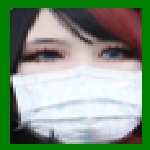

Image: mask6.png - Prediction: Mask (0.01)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


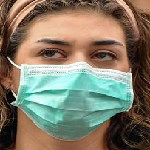

Image: mix_mask_3.jpg_face_1.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


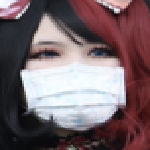

Image: w_mask_2.png_face_2.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


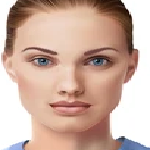

Image: test2.png_face_1.png - Prediction: No Mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


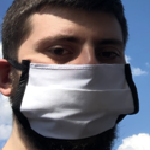

Image: w_mask_1.png_face_1.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


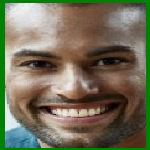

Image: no_mask4.png - Prediction: No Mask (0.67)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


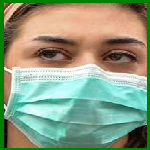

Image: mask1.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


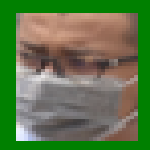

Image: mask0.png - Prediction: Mask (0.07)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


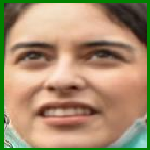

Image: wrong_mask.png - Prediction: No Mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


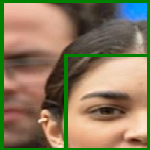

Image: no_mask2.png - Prediction: Mask (0.21)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


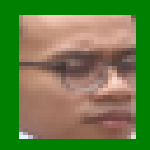

Image: no_mask0.png - Prediction: No Mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


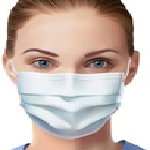

Image: test2.png_face_2.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


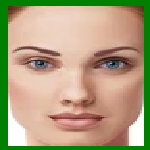

Image: no_mask5.png - Prediction: No Mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


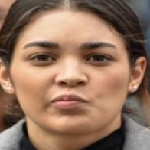

Image: mix_mask_3.jpg_face_2.png - Prediction: No Mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


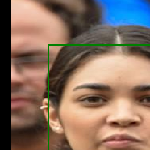

Image: mix_mask_3.jpg_face_4.png - Prediction: No Mask (0.86)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


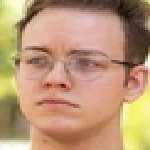

Image: test3.png_face_1.png - Prediction: No Mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


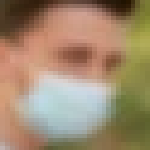

Image: test3.png_face_2.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


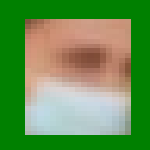

Image: mask3.png - Prediction: Mask (0.17)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


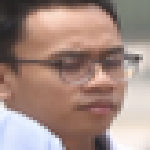

Image: mix_mask_2.png_face_2.png - Prediction: No Mask (0.99)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


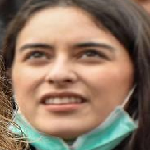

Image: mix_mask_3.jpg_face_3.png - Prediction: No Mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


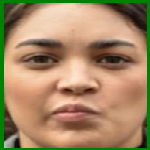

Image: no_mask1.png - Prediction: No Mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


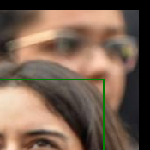

Image: mix_mask_3.jpg_face_5.png - Prediction: Mask (0.02)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


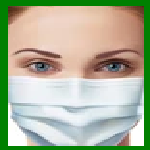

Image: mask2.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


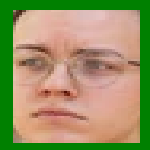

Image: no_mask6.png - Prediction: No Mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


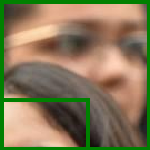

Image: no_mask3.png - Prediction: Mask (0.02)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


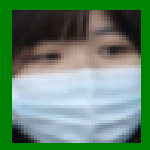

Image: mask5.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


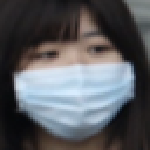

Image: w_mask_2.png_face_1.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


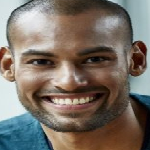

Image: test.jpg_face_1.png - Prediction: No Mask (0.90)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


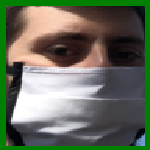

Image: mask4.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


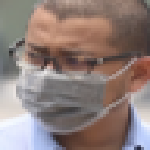

Image: mix_mask_2.png_face_1.png - Prediction: Mask (0.01)


In [6]:
# Folder containing images to test
test_images_folder = '../dataset/images/cropped'  # Update with your folder path

# Function to make predictions on individual images
def predict_images(folder_path):
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        # Load and preprocess the image
        img = load_img(image_path, target_size=(150, 150))  # Resize to match input size
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Make prediction
        prediction = model.predict(img_array)
        label = "Mask" if prediction[0][0] < 0.5 else "No Mask"
        display(img)
        print(f"Image: {image_name} - Prediction: {label} ({prediction[0][0]:.2f})")

# Call the function
predict_images(test_images_folder)
